In [1]:
# Download data, execute this block once in a while
# checks if dataset is downloaded at data/covid19-severity-prediction
# updating to the latest version
# Note: this can take a while if you don't have the dataset in data/covid19-severity-prediction

from utils import *

updating to the latest version
update successful
current working dir: d:\dataset\CS184A-Covid19_severity_prediction


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [3]:
import load_data
from Project_Models import RNN_Model, LSTM_Model
import torch
import torch.nn as nn

print("current device:", torch.cuda.get_device_name(torch.cuda.current_device()))

def normalize(x):
    """ normalize data of each column """
    maxtensor = x.max(0, keepdim=True)[0]
    maxtensor[maxtensor==0] = 1e-4
    x_normed = x / maxtensor
    return x_normed, maxtensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
df = load_data.load_county_level('./data/covid19-severity-prediction/data')

current device: GeForce RTX 3080
loading county-level data...
loaded and merged COVID-19 cases/deaths data successfully


In [4]:
def to_numpy(x):
    """Convert a PyTorch tensor to NumPy."""
    return x.squeeze().detach().cpu().numpy()

def to_torch(x, device='cpu'):
    return torch.tensor(x).unsqueeze(-1).to(device).float()

In [5]:
# df['HeartDiseaseMortality'][:20]

In [6]:
# [i for i in df.columns.tolist() if not (i.startswith("#Cases") or i.startswith("#Death"))]

In [7]:
# Preprocess Data

maxload = 200 # 1600

x = form_input_tensor(df, [
    '#Hospitals', 
    '#ICU_beds', 
    'MedicareEnrollment,AgedTot2017', 
    'DiabetesPercentage', 
    'HeartDiseaseMortality',
    'StrokeMortality',
    'Smokers_Percentage',
    'RespMortalityRate2014',
    '#FTEHospitalTotal2017',
    "TotalM.D.'s,TotNon-FedandFed2017",
    '#HospParticipatinginNetwork2017'],
    maxload=maxload).to(device)
x, xmaxtensor = normalize(x)
print(f"#x nan: {(torch.sum(torch.isnan(x)))}")
# print("x:", x)

y = form_labels_tensor(df, maxload=maxload).to(device)
y, ymaxtensor = normalize(y)
print(f"#y nan: {torch.sum(torch.isnan(y))}")
# print("y:", y * ymaxtensor)

Xtrain = x[:-50]
Ytrain = y[:-50]
Xtest  = x[90:]
Ytest  = y[90:]

#x nan: 0
#y nan: 0


In [8]:
import torch
import torch.nn as nn


class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
        self.activation=nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]

        out = self.activation(self.fc1(out))
        out = self.activation(self.fc2(out))
        out = self.fc3(out)
        return out

In [14]:
print("training data shape:", Xtrain.shape, Ytrain.shape)

# train model
Classifier = LSTM

model = Classifier(input_size=Xtrain.shape[2], hidden_size=128, num_layers=3).to(device)
# with torch.no_grad():
#     print("Before training:", model(Xtrain) * ymaxtensor)

criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss()
learning_rate = 1e-3
num_epoches = 100
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

trange = tqdm.trange(num_epoches)
for epoch in trange:
    yhat = model(Xtrain)
    loss = criterion(yhat, Ytrain)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    trange.set_description(f'Epoch [{epoch + 1}/{num_epoches}], Loss: {loss.item():.4f}')
    trange.refresh()

with torch.no_grad():
    print("After training:", (model(Xtest) * ymaxtensor))
    print("y:", (Ytest * ymaxtensor))

Epoch [100/100], Loss: 0.0030: 100%|██████████| 100/100 [00:07<00:00, 14.25it/s]
After training: tensor([[19611.2988,   606.6511],
        [19755.4668,   610.5558],
        [19954.9414,   615.9510],
        [18245.1699,   566.3822],
        [19888.0273,   612.0485],
        [22323.5703,   679.7471],
        [24828.9121,   749.1376],
        [17947.1484,   553.5142],
        [28854.8105,   865.1985],
        [14794.2168,   475.9769],
        [21361.7266,   643.2729],
        [20971.8574,   641.8272],
        [15932.3711,   506.5893],
        [17835.7324,   558.0314],
        [16695.7559,   525.1009],
        [19676.6328,   606.9175],
        [15547.0713,   495.8477],
        [10677.7178,   372.8507],
        [18068.6738,   563.2573],
        [21635.1367,   659.5494],
        [15472.4902,   488.7314],
        [15670.8311,   497.2886],
        [15973.7197,   508.7747],
        [14515.1816,   467.8995],
        [18116.3125,   561.4670],
        [17941.3418,   561.3410],
        [22296.2363

In [15]:
# Saving the model
# torch.save(model, "saved_model/first100dataloss=0.model")

In [16]:
# TODO
# 1. Batch Gradient Descent using dataloader
# 2. Handle NaN case

In [17]:
# df['CountyName'] == 'Orange'

mse 711184913.414966


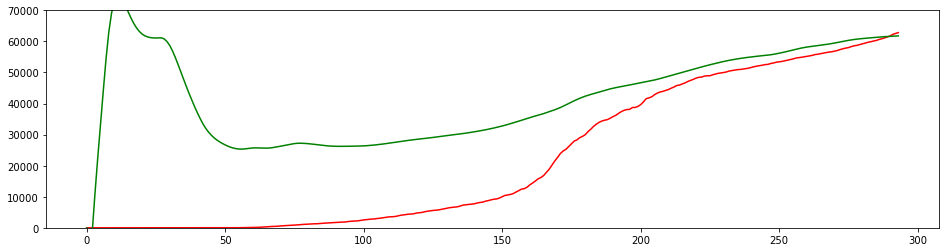

mse 806544.925170068


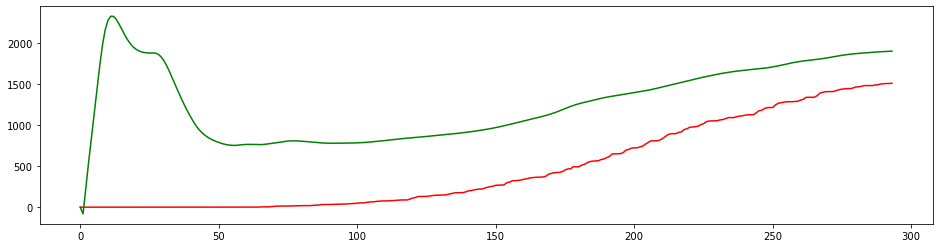

In [18]:
orange = df[(df['StateName'] == 'CA') & (df['CountyName'] == 'Orange')]

def plotPrediction(df):
    x = form_input_tensor(df, [
    '#Hospitals', 
    '#ICU_beds', 
    'MedicareEnrollment,AgedTot2017', 
    'DiabetesPercentage', 
    'HeartDiseaseMortality',
    'StrokeMortality',
    'Smokers_Percentage',
    'RespMortalityRate2014',
    '#FTEHospitalTotal2017',
    "TotalM.D.'s,TotNon-FedandFed2017",
    '#HospParticipatinginNetwork2017'], maxload=maxload).to(device)
    truey = x[:, :, -2:]
    xnorm = x / xmaxtensor
    # print(f"#x nan: {(torch.sum(torch.isnan(x)))}")
    # print("x:", x * )
    y = form_labels_tensor(df, maxload=maxload).to(device)
    ynorm = y / ymaxtensor
    # print(f"#y nan: {torch.sum(torch.isnan(y))}")

    yhat = torch.zeros((x.shape[1], 2), dtype=torch.float32, device='cuda')
    for i in range(1, x.shape[1]):
        yhati = None
        with torch.no_grad():
            yhati = model(xnorm[:,:i,:])
        yhati *= ymaxtensor
        yhat[i] = (yhati)
    # print(yhat)

    truey = to_numpy(truey)
    yhat = to_numpy(yhat)
    plt.figure(figsize=(16,4))
    plt.ylim((0, 70000))
    plt.plot(range(len(truey)),truey[:,0],'r-')
    plt.plot(range(len(truey)),yhat[:,0],'g-')
    # plt.plot(range(len(truey)), np.absolute(truey[:,0]-yhat[:,0]), 'b-')
    print("mse", np.sum((truey[:,0] - yhat[:,0]) ** 2) / len(truey))
    plt.show()
    plt.figure(figsize=(16,4))
    plt.plot(range(len(truey)),truey[:,1],'r-')
    plt.plot(range(len(truey)),yhat[:,1],'g-')
    # plt.plot(range(len(truey)), np.absolute(truey[:,1]-yhat[:,1]), 'b-')
    print("mse", np.sum((truey[:,1] - yhat[:,1]) ** 2) / len(truey))
    plt.show()

plotPrediction(orange)

In [ ]:
# with 2e-5 reg

print("training data shape:", Xtrain.shape, Ytrain.shape)

# train model
Classifier = LSTM

model = Classifier(input_size=Xtrain.shape[2], hidden_size=128, num_layers=3).to(device)
# with torch.no_grad():
#     print("Before training:", model(Xtrain) * ymaxtensor)

criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss()
learning_rate = 1e-3
num_epoches = 100
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=2e-5)

trange = tqdm.trange(num_epoches)
for epoch in trange:
    for i in range(1, Xtrain.shape[1]):
        yhat = model(Xtrain[:,:i,:])
        loss = criterion(yhat, Xtrain[:,i,-2:])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        trange.set_description(f'Epoch [{epoch + 1}/{num_epoches}], Loss: {loss.item():.4f}')
        trange.refresh()

with torch.no_grad():
    print("After training:", (model(Xtest) * ymaxtensor))
    print("y:", (Ytest * ymaxtensor))

In [ ]:
orange = df[(df['StateName'] == 'CA') & (df['CountyName'] == 'Orange')]

def plotPrediction(df):
    x = form_input_tensor(df, [
    '#Hospitals', 
    '#ICU_beds', 
    'MedicareEnrollment,AgedTot2017', 
    'DiabetesPercentage', 
    'HeartDiseaseMortality',
    'StrokeMortality',
    'Smokers_Percentage',
    'RespMortalityRate2014',
    '#FTEHospitalTotal2017',
    "TotalM.D.'s,TotNon-FedandFed2017",
    '#HospParticipatinginNetwork2017'], maxload=maxload).to(device)
    truey = x[:, :, -2:]
    xnorm = x / xmaxtensor
    # print(f"#x nan: {(torch.sum(torch.isnan(x)))}")
    # print("x:", x * )
    y = form_labels_tensor(df, maxload=maxload).to(device)
    ynorm = y / ymaxtensor
    # print(f"#y nan: {torch.sum(torch.isnan(y))}")

    yhat = torch.zeros((x.shape[1], 2), dtype=torch.float32, device='cuda')
    for i in range(1, x.shape[1]):
        yhati = None
        with torch.no_grad():
            yhati = model(xnorm[:,:i,:])
        yhati *= ymaxtensor
        yhat[i] = (yhati)
    # print(yhat)

    truey = to_numpy(truey)
    yhat = to_numpy(yhat)
    plt.figure(figsize=(16,4))
    plt.ylim((0, 70000))
    plt.plot(range(len(truey)),truey[:,0],'r-')
    plt.plot(range(len(truey)),yhat[:,0],'g-')
    # plt.plot(range(len(truey)), np.absolute(truey[:,0]-yhat[:,0]), 'b-')
    print("mse", np.sum((truey[:,0] - yhat[:,0]) ** 2) / len(truey))
    plt.show()
    plt.figure(figsize=(16,4))
    plt.plot(range(len(truey)),truey[:,1],'r-')
    plt.plot(range(len(truey)),yhat[:,1],'g-')
    # plt.plot(range(len(truey)), np.absolute(truey[:,1]-yhat[:,1]), 'b-')
    print("mse", np.sum((truey[:,1] - yhat[:,1]) ** 2) / len(truey))
    plt.show()

plotPrediction(orange)